In [3]:
import numpy as np
import numba as nb
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
from numba import njit, prange
from os import listdir
from os.path import isfile, join

%matplotlib inline
plt.style.use(['science','ieee'])

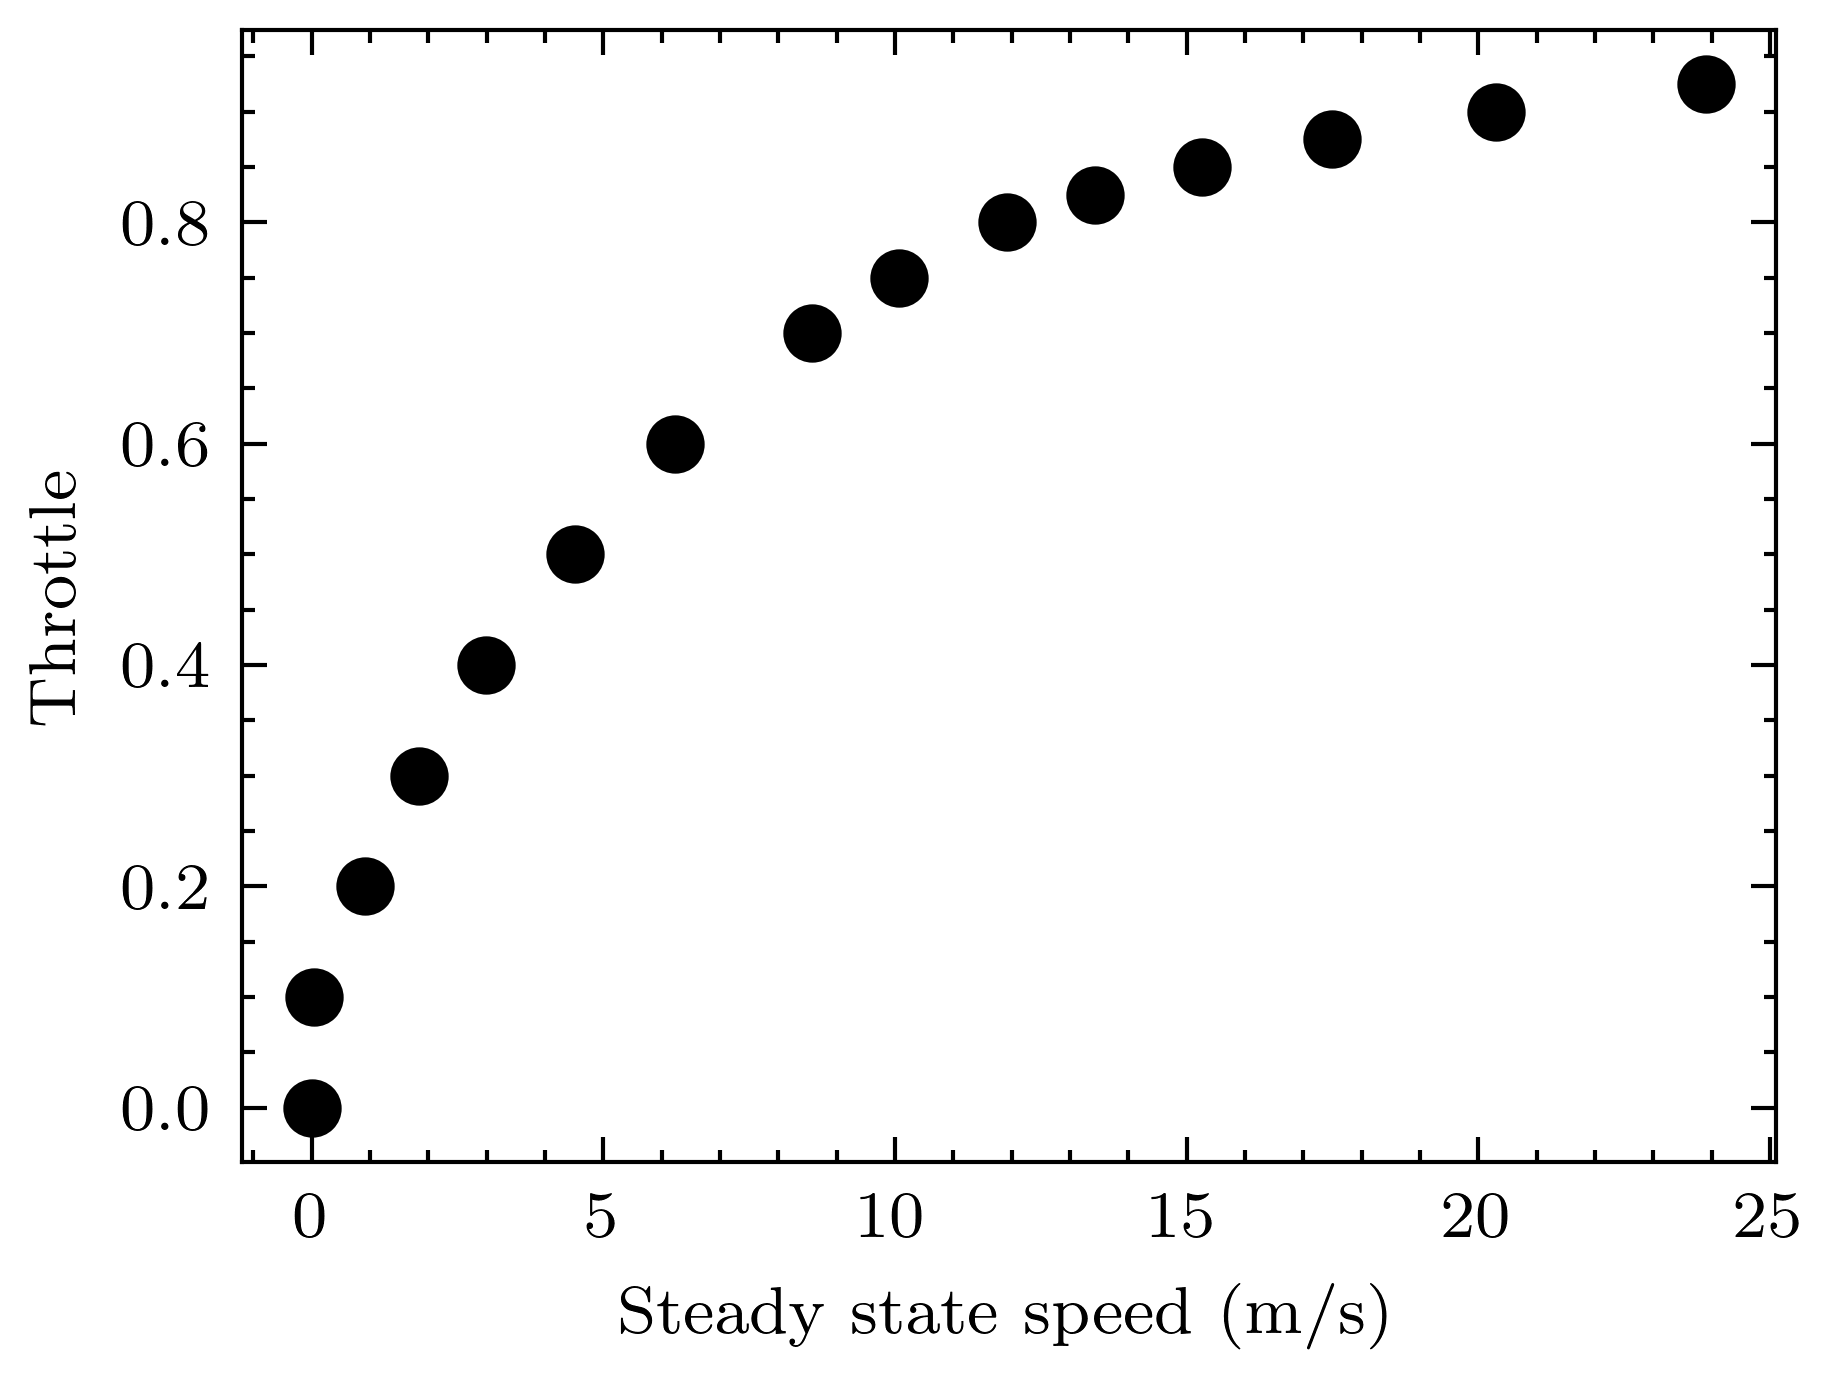

In [4]:
df = pd.read_csv('ssr/steady_state_response.csv')
v = np.array(df.ssv)
u = np.array(df.u)


plt.figure()
plt.scatter(v, u)
plt.xlabel('Steady state speed (m/s)')
plt.ylabel('Throttle')
plt.show()

In [5]:
def generate_population(num, dim, rng):
    """
    Generate population:
        Input:
            num: number of population (integer)
            dim: number of parameters (integer)
            rng: range number used in initialization (list or numpy array)
        Output:
            pop: initial position of the population (numpy array)
    """
    pop = np.zeros((num,dim))
    for i in range(dim):
        lim = rng[i]
        pop[:, i] = np.random.uniform(lim[0], lim[1], size=num)
    return pop

In [6]:
@njit
def admissible(param):
    b1, b2, b3 = param
    if b1 < 0. or b2 > 0. or b3 < 0.:
        return False
    else:
        return True
_ = admissible(np.random.randn(3))

In [7]:
@njit
def forward_propagation(u, param):
    b1, b2, b3 = param
    
    out = b1 * (1 - np.exp(b2*(u))) + b3
    out = np.fmax(out, 0.)
    
    # When the vehicle is not moving
    out[u <= 1e-2] = 0.
    
    return out

_ = forward_propagation(np.array([0.0, 0.1]), np.ones(3)*0.5)

In [8]:
@njit
def cost(u, v, param):
    error = v - forward_propagation(u, param)
    cost = np.dot(error.T, error)
    return cost
_ = cost(v, u, np.ones(3)*0.5)

In [9]:
@njit
def calculate_total_cost(param):    
    if admissible(param):
        loss = cost(v, u, param)
    else:
        loss = np.Inf
    return loss
_ = calculate_total_cost(np.ones(3)*0.5)

In [11]:
@njit(parallel=True)
def population_cost(population):
    length = population.shape[0]
    losses = np.zeros(length)
    for ii in prange(length):
        losses[ii] = calculate_total_cost(population[ii])
    return losses
_ = population_cost(np.random.randn(2,3))

## PSO

In [19]:
@njit
def pso(population, loss_population, global_, global_loss, w, c1, c2):
    num = population.shape[0]
    dim = population.shape[1]
    
    # Initial conditions
    ppos_vector = population
    pbest_pos = ppos_vector
    pfit_value = loss_population
    gbest_pos = global_
    gfit_value = global_loss
    pvel_vector = np.zeros((num, dim))
    
    for i in range(num):
        # Update the velocity and position vector
        pvel_vector[i] = w*pvel_vector[i] + c1*np.random.random()*(pbest_pos[i]-ppos_vector[i]) + c2*np.random.random()*(gbest_pos-ppos_vector[i])
        ppos_vector[i] = pvel_vector[i] + ppos_vector[i]
        
        cost_func = calculate_total_cost(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
    
    return pbest_pos, pfit_value, gbest_pos, gfit_value
    
xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = pso(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1)

In [40]:
num = 25
n_sim = 50
n_itr = 1000

r_b1 = [0., 1.]
r_b2 = [0., -1.]
r_b3 = [0., 1.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

w = 0.5
c1 = 0.7
c2 = 0.8

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim)*np.Inf

best_param_history = np.zeros((n_itr, dim))
best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    population = generate_population(num, dim, rng)
    global_ = None
    global_loss_ = np.Inf
    
    loss_population = population_cost(population)
    loss_population[np.isnan(loss_population)] = np.Inf
    min_idx = np.argmin(loss_population)
    min_loss = loss_population[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = population[min_idx, :]
        
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Particle Swarm Optimization
        population, loss_population, global_, global_loss_ = pso(population, loss_population, global_, global_loss_, w, c1, c2)
        
        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || the best loss: {:.10f}'.format(j+1, the_best_loss_history[-1]))

simulation: 1 || the best loss: 0.0212601078
simulation: 2 || the best loss: 0.0212601078
simulation: 3 || the best loss: 0.0212601078
simulation: 4 || the best loss: 0.0212601078
simulation: 5 || the best loss: 0.0092372509
simulation: 6 || the best loss: 0.0092372509
simulation: 7 || the best loss: 0.0092372509
simulation: 8 || the best loss: 0.0092372509
simulation: 9 || the best loss: 0.0092372509
simulation: 10 || the best loss: 0.0092372509
simulation: 11 || the best loss: 0.0092372509
simulation: 12 || the best loss: 0.0092372509
simulation: 13 || the best loss: 0.0092372509
simulation: 14 || the best loss: 0.0092372509
simulation: 15 || the best loss: 0.0092372509
simulation: 16 || the best loss: 0.0092372509
simulation: 17 || the best loss: 0.0092372509
simulation: 18 || the best loss: 0.0092372509
simulation: 19 || the best loss: 0.0092372509
simulation: 20 || the best loss: 0.0092372509
simulation: 21 || the best loss: 0.0092372509
simulation: 22 || the best loss: 0.00923725

## APSO

In [43]:
@njit
def apso(population, loss_population, global_, global_loss, alpha0, beta, gamma, n_itr):
    num = population.shape[0]
    dim = population.shape[1]
    
    # Initial conditions
    ppos_vector = population
    pbest_pos = ppos_vector
    pfit_value = loss_population
    gbest_pos = global_
    gfit_value = global_loss
    pvel_vector = np.zeros((num, dim))
    
    for i in range(num):
        # Update the alpha value
        alpha = alpha0*gamma**n_itr
            
        # Update the velocity and position vector
        ppos_vector[i] = (1-beta)*ppos_vector[i] + alpha*np.random.normal(0,1) + beta*gbest_pos
        
        cost_func = calculate_total_cost(ppos_vector[i])
        
        # Update each values using the cost functions
        if(pfit_value[i] > cost_func):
            pfit_value[i] = cost_func
            pbest_pos[i] = np.copy(ppos_vector[i])
                
        if(gfit_value > cost_func):
            gfit_value = cost_func
            gbest_pos = np.copy(ppos_vector[i])
    
    return pbest_pos, pfit_value, gbest_pos, gfit_value
    
xx1 = np.ones((2, 3))*1.0
xx2 = np.ones(2)
xx3 = np.ones(3)*0.5
_ = apso(xx1, xx2, xx3, 100.0, 0.8, 1.5, 0.1, 5)

In [44]:
num = 25
n_sim = 50
n_itr = 1000

r_b1 = [0., 1.]
r_b2 = [0., -1.]
r_b3 = [0., 1.]

rng = [r_b1, r_b2, r_b3]
dim = len(rng)

alpha0 = 0.6
beta = 0.5
gamma = 0.8

param_history = np.zeros((n_sim, dim))
loss_history = np.ones(n_sim)*np.Inf

best_param_history = np.zeros((n_itr, dim))
best_loss_history = np.zeros(n_itr)

for j in range(n_sim):
    population = generate_population(num, dim, rng)
    global_ = None
    global_loss_ = np.Inf
    
    loss_population = population_cost(population)
    loss_population[np.isnan(loss_population)] = np.Inf
    min_idx = np.argmin(loss_population)
    min_loss = loss_population[min_idx]
    if global_loss_ > min_loss:
        global_loss_ = min_loss
        global_ = population[min_idx, :]
        
    global_history = np.empty((n_itr, dim))
    global_history[0] = global_
    global_loss_history = np.empty(n_itr)
    global_loss_history[0] = global_loss_
    for i in range(1, n_itr):
        # Particle Swarm Optimization
        population, loss_population, global_, global_loss_ = apso(population, loss_population, global_, global_loss_, alpha0, beta, gamma, j+1)
        
        global_history[i] = global_
        global_loss_history[i] = global_loss_
    
    if np.min(loss_history) > global_loss_history[-1]:
        the_best_loss_history = np.copy(global_loss_history)
        the_best_param_history = np.copy(global_history)
        
    param_history[j] = np.copy(global_history[-1])
    loss_history[j] = np.copy(global_loss_history[-1])
    
    print('simulation: {} || the best loss: {:.10f}'.format(j+1, the_best_loss_history[-1]))

simulation: 1 || the best loss: 0.1919121006
simulation: 2 || the best loss: 0.0544955622
simulation: 3 || the best loss: 0.0544955622
simulation: 4 || the best loss: 0.0544955622
simulation: 5 || the best loss: 0.0544955622
simulation: 6 || the best loss: 0.0544955622
simulation: 7 || the best loss: 0.0544955622
simulation: 8 || the best loss: 0.0544955622
simulation: 9 || the best loss: 0.0544955622
simulation: 10 || the best loss: 0.0380243360
simulation: 11 || the best loss: 0.0101323030
simulation: 12 || the best loss: 0.0101323030
simulation: 13 || the best loss: 0.0101323030
simulation: 14 || the best loss: 0.0043016823
simulation: 15 || the best loss: 0.0043016823
simulation: 16 || the best loss: 0.0043016823
simulation: 17 || the best loss: 0.0043016823
simulation: 18 || the best loss: 0.0043016823
simulation: 19 || the best loss: 0.0043016823
simulation: 20 || the best loss: 0.0043016823
simulation: 21 || the best loss: 0.0037570693
simulation: 22 || the best loss: 0.00375706